<a href="https://colab.research.google.com/github/subandwho/tensorflow/blob/main/NLP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-915dbe1e-9899-a301-b889-2fe899010346)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-21 08:30:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-21 08:30:11 (63.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2021-07-21 08:30:14--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 66.102.1.128, 172.253.120.128, 142.251.5.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|66.102.1.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-07-21 08:30:14 (92.7 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [5]:
unzip_data('nlp_getting_started.zip')

In [6]:
import pandas as pd
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df_shuffle = train_df.sample(frac = 1, random_state = 42)
train_df_shuffle.head(5)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [8]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [10]:
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffle[['text', 'target']][random_index:random_index+5].itertuples():
   _, text, target = row
   print(f"Target: {target}", "{real_disaster}" if target >0 else "{not disaster}")
   print(f"Text:\n{text}\n")
   print("===\n")

Target: 1 {real_disaster}
Text:
#hot  C-130 specially modified to land in a stadium and rescue hostages in Iran in 1980 http://t.co/wpGvAyfkBQ #prebreak #best

===

Target: 0 {not disaster}
Text:
RT: Our_Mother_Mary: Short Reading

Apocalypse 21:1023 

In the spirit the angel took me to the top of an enormous high mountain and... Û_

===

Target: 0 {not disaster}
Text:
I added a video to a @YouTube playlist http://t.co/wedWyn9kfS World Of Tanks - Battle Assistant Mod Bat Chat Arti kaboom

===

Target: 1 {real_disaster}
Text:
#ModiMinistry Railway Minister Prabhu calls MP derailment a natural calamity http://t.co/tL41olpAkZ

===

Target: 0 {not disaster}
Text:
Rappers stop sampling police sirens and start sampling whale song.????

===



In [11]:
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffle['text'].to_numpy(),
                                                                            train_df_shuffle['target'].to_numpy(),
                                                                                             test_size = 0.1, random_state=42)

In [12]:
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [13]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [14]:
text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize ="lower_and_strip_punctuation",
                                    split ="whitespace",
                                    ngrams=None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens = True)

In [15]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))


15

In [16]:
max_vocab_length = 10000
max_length = 15
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [17]:
text_vectorizer.adapt(train_sentences)

In [18]:
random_sentence = random.choice(train_sentences)
text_vectorizer([random_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[6184,  899,   62, 1529,   22,   12,   16, 1370,    9,  115,  899,
         180,    0,    0,    0]])>

In [19]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:5]

['', '[UNK]', 'the', 'a', 'in']

In [20]:
from tensorflow.keras import layers
embedding = layers.Embedding(input_dim=max_vocab_length,
                             output_dim=128,
                             input_length=max_length)

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ('clf', MultinomialNB())
])
model_0.fit(train_sentences, train_labels)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baselinemodel score: {baseline_score*100:.2f}")

Baselinemodel score: 79.27


In [23]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [24]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)*100
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall":model_recall,
                   "f1":model_f1}
  return model_results                 

In [25]:
baseline_results = calculate_results(y_true = val_labels,
                                     y_pred = baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [26]:
from helper_functions import create_tensorboard_callback

SAVE_DIR = "model_log"
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs, name='Output')
model_1.summary()

Model: "Output"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [27]:
model_1.compile(loss='binary_crossentropy', 
                optimizer= 'Adam',
                metrics=['accuracy'])
model_1_history = model_1.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name = SAVE_DIR, experiment_name='Model_1')])

Saving TensorBoard log files to: model_log/Model_1/20210721-083024
Epoch 1/5
215/215 [==============================] - 8s 21ms/step - loss: 0.6133 - accuracy: 0.6895 - val_loss: 0.5346 - val_accuracy: 0.7585
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4424 - accuracy: 0.8186 - val_loss: 0.4675 - val_accuracy: 0.7874
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.3465 - accuracy: 0.8624 - val_loss: 0.4596 - val_accuracy: 0.7966
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2843 - accuracy: 0.8859 - val_loss: 0.4665 - val_accuracy: 0.7940
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2371 - accuracy: 0.9108 - val_loss: 0.4793 - val_accuracy: 0.7835


In [28]:
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs

array([[4.00481790e-01],
       [7.73064137e-01],
       [9.97886598e-01],
       [1.53758854e-01],
       [1.03835762e-01],
       [9.38405752e-01],
       [9.04680073e-01],
       [9.92819607e-01],
       [9.70442414e-01],
       [3.24510932e-01],
       [1.12657174e-01],
       [6.70295358e-01],
       [4.79855314e-02],
       [1.85229436e-01],
       [4.23567044e-03],
       [1.35733992e-01],
       [2.32355557e-02],
       [7.96887428e-02],
       [2.73073226e-01],
       [5.51558733e-01],
       [9.10833597e-01],
       [3.50559615e-02],
       [4.51352537e-01],
       [9.89643335e-02],
       [9.59813297e-01],
       [9.98694360e-01],
       [3.94163877e-02],
       [7.75594413e-02],
       [2.99471989e-02],
       [1.77889377e-01],
       [5.83275378e-01],
       [2.93462694e-01],
       [5.01953781e-01],
       [1.79536089e-01],
       [5.02046466e-01],
       [5.95003292e-02],
       [9.94213998e-01],
       [1.94764555e-01],
       [3.14140953e-02],
       [9.98241425e-01],


In [29]:
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_1_preds)

In [30]:
model_1_results

{'accuracy': 78.34645669291339,
 'f1': 0.7809185675137833,
 'precision': 0.7868445599717488,
 'recall': 0.7834645669291339}

In [31]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [32]:
word_in_vocab = text_vectorizer.get_vocabulary()
#weights matrix of tokens

embed_weights = model_1.get_layer("embedding").get_weights()[0]


In [33]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(word_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [34]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
#NLP WITH LSTM (RNNs)

from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string, name='Input_Layer')
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')

In [36]:
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
model_2_history = model_2.fit(train_sentences, train_labels,
                              epochs=5, validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 'model_2_LSTM')])

Saving TensorBoard log files to: model_log/model_2_LSTM/20210721-083108
Epoch 1/5
215/215 [==============================] - 10s 26ms/step - loss: 0.2214 - accuracy: 0.9212 - val_loss: 0.5988 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 4s 21ms/step - loss: 0.1594 - accuracy: 0.9406 - val_loss: 0.6744 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1257 - accuracy: 0.9517 - val_loss: 0.6909 - val_accuracy: 0.7808
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.1115 - accuracy: 0.9602 - val_loss: 0.7911 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 5s 21ms/step - loss: 0.0874 - accuracy: 0.9679 - val_loss: 0.9087 - val_accuracy: 0.7756


In [38]:
model_2_pred_probs = model_2.predict(val_sentences)
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))

In [39]:
model_2_results = calculate_results(val_labels,
                                    model_2_preds)
model_2_results

{'accuracy': 77.55905511811024,
 'f1': 0.7725109164504043,
 'precision': 0.7797991425654591,
 'recall': 0.7755905511811023}

In [40]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [41]:
#NLP WITH GRU
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string,
                      name='Input_Layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, name='GRU_LAYER')(x)
#x= layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs, name='MODEL_3_GRU')
model_3.compile(loss='binary_crossentropy',
                optimizer= 'Adam',
                metrics=['accuracy'])
model_3.fit(train_sentences, train_labels,
            epochs=5, validation_data = (val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='MODEL_3_GRU')])

Saving TensorBoard log files to: model_log/MODEL_3_GRU/20210721-083137
Epoch 1/5
215/215 [==============================] - 8s 26ms/step - loss: 0.1525 - accuracy: 0.9394 - val_loss: 0.7906 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0835 - accuracy: 0.9679 - val_loss: 0.7700 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0717 - accuracy: 0.9721 - val_loss: 1.0995 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0593 - accuracy: 0.9758 - val_loss: 1.0143 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0535 - accuracy: 0.9772 - val_loss: 0.9995 - val_accuracy: 0.7677


In [42]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))

In [43]:
model_3_results = calculate_results(val_labels,
                                    model_3_preds)
model_3_results

{'accuracy': 76.77165354330708,
 'f1': 0.7664937875658134,
 'precision': 0.7678558301291274,
 'recall': 0.7677165354330708}

In [44]:
#NLP USING BI-Directional

inputs = layers.Input(shape=(1,), name='Input_Layer',
                      dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4 = tf.keras.Model(inputs, outputs, name = 'BIdirectional')

In [45]:
model_4.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
model_4.fit(train_sentences, train_labels,
            epochs=5, validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='MODEL_4_Bidir')])

Saving TensorBoard log files to: model_log/MODEL_4_Bidir/20210721-083204
Epoch 1/5
215/215 [==============================] - 16s 46ms/step - loss: 0.1028 - accuracy: 0.9651 - val_loss: 0.9402 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0535 - accuracy: 0.9780 - val_loss: 1.4887 - val_accuracy: 0.7585
Epoch 3/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0513 - accuracy: 0.9780 - val_loss: 1.2322 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 7s 35ms/step - loss: 0.0440 - accuracy: 0.9799 - val_loss: 1.3864 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0429 - accuracy: 0.9799 - val_loss: 1.4915 - val_accuracy: 0.7664


In [46]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_results = calculate_results(val_labels, model_4_preds)

In [47]:
model_4_results

{'accuracy': 76.64041994750657,
 'f1': 0.764784113056577,
 'precision': 0.7670590562420062,
 'recall': 0.7664041994750657}

In [48]:
#NLP WITH CONV1D

inputs = layers.Input(shape=(1,), dtype=tf.string, name='Input_Layer')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64, kernel_size = 3, padding='valid',
                  activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = 'sigmoid',
                       name='Output_Name')(x)
model_5 = tf.keras.Model(inputs, outputs, name='Model-5_Conv1D')
model_5.summary()

Model: "Model-5_Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding (Embedding)        (None, 15, 128)           1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 64)            24640     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
Output_Name (Dense)          (None, 1)                 65        
Total params: 1,304,705
Trainable params: 1,304,705
Non-trainable params: 0
__________________________________________

In [49]:
model_5.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
model_5.fit(train_sentences, train_labels,
            epochs=5, validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='MODEL_5_CONV1D')])

Saving TensorBoard log files to: model_log/MODEL_5_CONV1D/20210721-083254
Epoch 1/5
215/215 [==============================] - 29s 22ms/step - loss: 0.1694 - accuracy: 0.9504 - val_loss: 0.8149 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0875 - accuracy: 0.9673 - val_loss: 0.9983 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0695 - accuracy: 0.9723 - val_loss: 1.1033 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 4s 18ms/step - loss: 0.0606 - accuracy: 0.9729 - val_loss: 1.2137 - val_accuracy: 0.7520
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0566 - accuracy: 0.9759 - val_loss: 1.2813 - val_accuracy: 0.7638


In [50]:
model_5_pred_probs = model_5.predict(val_sentences)
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_results = calculate_results(y_true=val_labels, y_pred=model_5_preds)
model_5_results

{'accuracy': 76.37795275590551,
 'f1': 0.7616372852178903,
 'precision': 0.7652161443395734,
 'recall': 0.7637795275590551}

In [59]:
#Transfer Learning NLP

import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable=False,
                                        input_shape=[],
                                        dtype=tf.string,
                                        name='USE')
model_6 = tf.keras.Sequential([sentence_encoder_layer,
                               layers.Dense(64, activation='sigmoid'),
                               layers.Dense(1, activation='sigmoid'),
                               ],
                              name='model_6_USE')
model_6.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
model_6_history = model_6.fit(train_sentences,
                              train_labels, epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='MODEL_6_USE')])


Saving TensorBoard log files to: model_log/MODEL_6_USE/20210721-084713
Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.6135 - accuracy: 0.6946 - val_loss: 0.5415 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4873 - accuracy: 0.8043 - val_loss: 0.4732 - val_accuracy: 0.7992
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4405 - accuracy: 0.8086 - val_loss: 0.4566 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4232 - accuracy: 0.8133 - val_loss: 0.4506 - val_accuracy: 0.7979
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4143 - accuracy: 0.8167 - val_loss: 0.4479 - val_accuracy: 0.8045


In [77]:
model_6_pred_probs = model_6.predict(val_sentences)
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_results = calculate_results(y_true=val_labels,
                            y_pred=model_6_preds)
model_6_preds


<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0

In [73]:
model_7 = tf.keras.Sequential([sentence_encoder_layer,
                               layers.Dense(64, activation='sigmoid'),
                               layers.Dense(1, activation='sigmoid'),
                               ],
                              name='model_7_USE')
model_7.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent, epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, experiment_name='MODEL_7_USE')])

Saving TensorBoard log files to: model_log/MODEL_7_USE/20210721-090128
Epoch 1/5
24/24 [==============================] - 3s 102ms/step - loss: 0.7188 - accuracy: 0.4717 - val_loss: 0.6722 - val_accuracy: 0.7388
Epoch 2/5
24/24 [==============================] - 1s 43ms/step - loss: 0.6579 - accuracy: 0.6097 - val_loss: 0.6439 - val_accuracy: 0.6037
Epoch 3/5
24/24 [==============================] - 1s 44ms/step - loss: 0.6328 - accuracy: 0.7267 - val_loss: 0.6182 - val_accuracy: 0.8018
Epoch 4/5
24/24 [==============================] - 1s 44ms/step - loss: 0.6100 - accuracy: 0.7950 - val_loss: 0.5961 - val_accuracy: 0.8058
Epoch 5/5
24/24 [==============================] - 1s 43ms/step - loss: 0.5888 - accuracy: 0.8081 - val_loss: 0.5755 - val_accuracy: 0.8097


In [87]:
model_7_pred_probs = model_7.predict(val_sentences)
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
results = calculate_results(y_true=val_labels,
                            y_pred=model_7_preds)
model_7_preds.shape


TensorShape([762])

In [75]:
train_10_percent_split = int(0.1*len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [81]:
import pandas as pd
all_model_results = pd.DataFrame({"baseline":baseline_results,
                                  "model_1": model_1_results,
                                  "model_2":model_2_results,
                                  "model_3":model_3_results,
                                  "model_4":model_4_results,
                                  "model_5":model_5_results,
                                  "model_6":model_6_results,
                                  "model_7":results})
all_model_results = all_model_results.transpose()

In [82]:
all_model_results['accuracy'] = all_model_results['accuracy']/100

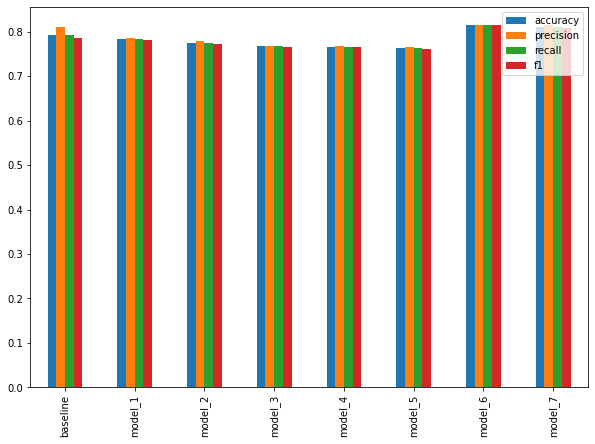

In [83]:
all_model_results.plot(kind='bar', figsize=(10,7))

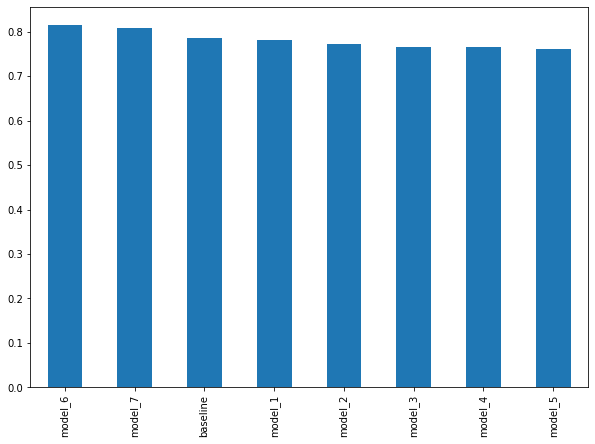

In [85]:
all_model_results.sort_values('f1', ascending=False)['f1'].plot(kind='bar', figsize=(10, 7))

In [86]:
!tensorboard dev upload --logdir ./model_logs/\
 --name "NLP Models on Tweets for Disaster"

2021-07-21 09:27:33.658441: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_logs/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3

762